<a href="https://colab.research.google.com/github/gabipalacios/Python/blob/main/RiesgoZ2capa_V11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [794]:
import numpy as np
import pandas as pd
import datetime as dt
import io
from google.colab import files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from google.colab import drive
pd.options.display.float_format = '{:.2f}'.format

drive.mount('/content/drive')
origen = pd.read_csv('/content/drive/MyDrive/1Empleos/VALOR/1bbddPhyton/bbdd_sinpagos1.csv')
marco = pd.read_csv('/content/drive/MyDrive/1Empleos/VALOR/1bbddPhyton/bbdd_PreMarcoBCU.csv')

#Variables seleccionadas del maro:
marco = marco.add_prefix('m_')
#Variables seleccionadas de Financial y PLataforma
origen = origen.add_prefix('o_')

#Elimino campos,tratando de evitar riesgos de plataforma y campos repetidos y con inconvenientes, (analizados previamente)
origen = origen.drop(['o_monto', 'o_cuota', 'o_tasa', 'o_plazo', 'o_cargo_originacion', 'o_tiene_seguro', 'o_tiene_cargo_adm',
                      'o_clr_score_if', 'o_clr_bp_fecha', 'o_rpf_alert', 'o_cdr_tiene_quita', 'o_cdr_tiene_oca', 'o_cdr_tiene_oca.1',
                      'o_cdr_tiene_financiera', 'o_cdr_tiene_brou', 'o_cdr_tiene_banco_privado', 'o_cdr_sum_deudas_ui', 'o_cdr_periodo',
                      'o_cdr_peor_calificacion', 'o_cdr_max_contingencia_ui', 'o_Tipo_Producto', 'o_Tipo Basico', 'o_clr_fecha',
                      'o_Canal', 'o_no_of_desc', 'o_id_solicitud', 'o_DesembolsoLugar', 'o_estado_tc', 'o_estado_pa',
                      'o_estado_cliente', 'o_cargo', 'o_meses_con_pagos', 'o_dias_atraso_max', 'o_DesembolsoSubAge.',
                      'o_DesembolsoAgencia', 'o_DesembolsoAgencia.1', 'o_CuotasPagas', 'o_localidad', 'o_Atraso', 'o_Solicitud',
                      'o_Fecha', 'o_tiene_tel_fijo', 'o_tiene_recibo_sueldo', 'o_Id_Clliente','o_Semana_año','o_Día'], axis=1)

#join de las dos tablas
df = pd.merge(origen, marco, left_on='o_Documento', right_on='m_Documento', how='inner')
#Defino índice documento
df = df.set_index('m_Documento')
#Quito registros que no tienen score
df = df.dropna(subset=['o_clr_score'])

#Reorganizo valores de variables con criterio lógico, para obtener mejore conclusiones, (analizados previamente)
df.loc[~df['o_dispositivo_marca'].isin(['Apple']), 'o_dispositivo_marca'] = 'Android'
df.loc[df['o_sist_op_familia'] != 'iOS', 'o_sist_op_familia'] = 'Android'
df.loc[df['o_dispositivo_marca'] != 'Apple', 'o_dispositivo_marca'] = 'Android'
df.loc[~df['o_navegador_familia'].isin(['Facebook', 'Instagram']), 'o_navegador_familia'] = 'Web'
df.loc[~df['o_departamento'].isin(['MONTEVIDEO', 'CANELONES']), 'o_departamento'] = 'RESTO'
df['o_Zero'] = np.where(df['o_Zero'] == 'Zero', 1, 0)
df['o_clr_accion'] = np.where(df['o_clr_accion'].isin(['C2', 'C1_3_3','C4','C1_2_3','C1_3_6','C1_3_1','C3']), df['o_clr_accion'], 'Varios')

print(df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1004, 39)


In [795]:
print(marco.shape)
print(origen.shape)
print(df.shape)

(2445, 13)
(1981, 27)
(1004, 39)


In [796]:
df = df.drop(['o_Documento'], axis=1)

In [797]:
marco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   m_Documento           2445 non-null   int64  
 1   m_Entidades           2445 non-null   int64  
 2   m_Exposición          2445 non-null   int64  
 3   m_Deuda               2445 non-null   int64  
 4   m_Rel_DeudaPrincipal  2445 non-null   float64
 5   m_Contingencia        2445 non-null   int64  
 6   m_Var_dueda_3M        2445 non-null   float64
 7   m_Sin_Ficha           2445 non-null   int64  
 8   m_Malos               2445 non-null   int64  
 9   m_Grupo_b             2445 non-null   object 
 10  m_Grupo_i             2445 non-null   object 
 11  m_Q_irregular_12m     2445 non-null   int64  
 12  m_Mejora              2445 non-null   int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 248.4+ KB


In [798]:
#Modificar el parámetro de la tabla df['hora'] donde se muestran las horas del día desde 0 a 23,
#son tipos de datos periódicos, utilizando el cálculo trigonométrico más adecuado para introducir el parámetro en un modelo predictivo.
df['o_Hora'] = pd.to_numeric(df['o_Hora'])

# Calcular la representación sinusoidal de la hora
df['hora_sin'] = np.sin(2 * np.pi * df['o_Hora'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['o_Hora'] / 24)

# Eliminar la columna original 'hora'
df = df.drop('o_Hora', axis=1)


In [799]:
origen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981 entries, 0 to 1980
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   o_Documento                 1981 non-null   int64  
 1   o_Quincena                  1981 non-null   int64  
 2   o_Hora                      1981 non-null   int64  
 3   o_Num_Dia_Sem               1981 non-null   int64  
 4   o_Zero                      1981 non-null   object 
 5   o_TEA                       1981 non-null   float64
 6   o_status_usuario            1981 non-null   object 
 7   o_status                    1981 non-null   object 
 8   o_sist_op_familia           1972 non-null   object 
 9   o_relacion_laboral          1981 non-null   object 
 10  o_plazo_hasta               1979 non-null   float64
 11  o_nivel_educativo           1981 non-null   object 
 12  o_nivel_antiguedad_laboral  1981 non-null   int64  
 13  o_navegador_familia         1972 

In [800]:
#Quito variables propas del modelo plataforma para evitar sesgos:
df = df.drop(['o_TEA', 'o_plazo_hasta', 'o_monto_maximo','o_mejor_esquema_pricing','o_ingreso_estimado','o_Cuotas','o_Capital'], axis=1)

In [801]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   o_Quincena                  1004 non-null   int64  
 1   o_Num_Dia_Sem               1004 non-null   int64  
 2   o_Zero                      1004 non-null   int64  
 3   o_status_usuario            1004 non-null   object 
 4   o_status                    1004 non-null   object 
 5   o_sist_op_familia           1004 non-null   object 
 6   o_relacion_laboral          1004 non-null   object 
 7   o_nivel_educativo           1004 non-null   object 
 8   o_nivel_antiguedad_laboral  1004 non-null   int64  
 9   o_navegador_familia         1004 non-null   object 
 10  o_ingreso_declarado         1004 non-null   int64  
 11  o_genero                    1004 non-null   object 
 12  o_edad                      1004 non-null   int64  
 13  o_dispositivo_marca        

In [802]:
print(df.o_relacion_laboral.unique())
df.o_relacion_laboral.value_counts()

['indep_sin_local' 'otros' 'emp_publico' 'jubilado' 'emp_privado'
 'indep_con_local']


,count
o_relacion_laboral,
emp_privado,358
indep_sin_local,163
jubilado,148
emp_publico,129
indep_con_local,104
otros,102


In [803]:
df['m_Var_dueda_3M'] = np.where(df['m_Var_dueda_3M'] > 2, 1, 0)

In [804]:
columns_to_categorize = ['o_Quincena', 'o_Num_Dia_Sem','m_Contingencia','m_Sin_Ficha','m_Malos','m_Mejora','m_Q_irregular_12m','m_Var_dueda_3M']

for col in columns_to_categorize:
  if col in df.columns:
    df[col] = df[col].astype('category')
  else:
    print(f"Warning: Column '{col}' not found in DataFrame.")

In [805]:
df_cat = df.select_dtypes(include=['object'])

# Transform all categorical variables into 'category' dtype
for col in df_cat.columns:
  df[col] = df[col].astype('category')

#df.info()

In [806]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   o_Quincena                  1004 non-null   category
 1   o_Num_Dia_Sem               1004 non-null   category
 2   o_Zero                      1004 non-null   int64   
 3   o_status_usuario            1004 non-null   category
 4   o_status                    1004 non-null   category
 5   o_sist_op_familia           1004 non-null   category
 6   o_relacion_laboral          1004 non-null   category
 7   o_nivel_educativo           1004 non-null   category
 8   o_nivel_antiguedad_laboral  1004 non-null   int64   
 9   o_navegador_familia         1004 non-null   category
 10  o_ingreso_declarado         1004 non-null   int64   
 11  o_genero                    1004 non-null   category
 12  o_edad                      1004 non-null   int64   
 13  o_dispositiv

In [807]:
df_cat = df.select_dtypes(include=['category'])
display(df_cat)

,o_Quincena,o_Num_Dia_Sem,o_status_usuario,o_status,o_sist_op_familia,o_relacion_laboral,o_nivel_educativo,o_navegador_familia,o_genero,o_dispositivo_marca,...,o_clr_accion,o_cel_carrier,m_Contingencia,m_Var_dueda_3M,m_Sin_Ficha,m_Malos,m_Grupo_b,m_Grupo_i,m_Q_irregular_12m,m_Mejora
m_Documento,,,,,,,,,,,,,,,,,,,,,
38753940,1,4,bureau_validated,validated_contact,Android,indep_sin_local,Primaria,Instagram,femenino,Android,...,C2,ANTEL,0,0,0,0,C,C,0,0
34006632,1,7,user_unvalidated_image,voucher_voided,Android,otros,Primaria,Web,femenino,Android,...,C1_3_3,ANTEL,1,0,0,0,C,C,0,0
37438759,1,2,idp_validated,eval_no_offer,Android,otros,Secundaria - Ciclo Básico,Facebook,femenino,Android,...,C1_3_6,MOVISTAR,1,0,0,0,C,C,0,0
36127012,2,2,id_verified,voucher_issued,Android,emp_publico,Primaria,Facebook,masculino,Android,...,C2,ANTEL,1,0,0,0,B1,B1,0,0
13295068,2,7,id_verified,voucher_issued,Android,jubilado,Secundaria - Bachillerato,Web,masculino,Android,...,C2,MOVISTAR,1,0,0,0,R,B1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39040629,1,4,id_verified,voucher_issued,Android,emp_publico,Secundaria - Ciclo Básico,Web,masculino,Android,...,C1_2_3,ANTEL,1,0,0,0,B1,B1,0,0
33515436,1,7,id_verified,voucher_issued,Android,jubilado,Secundaria - Bachillerato,Web,masculino,Android,...,C1_3_6,ANTEL,1,0,0,0,R,C,0,0
16411833,2,4,id_verified,voucher_issued,Android,jubilado,Educación Inicial,Web,masculino,Android,...,C1_3_1,MOVISTAR,1,0,0,0,M,C,1,2


In [808]:
for column in df_cat.columns:
  print(f"Unique values for {column}: {df_cat[column].unique()}")

Unique values for o_Quincena: [1, 2]
Categories (2, int64): [1, 2]
Unique values for o_Num_Dia_Sem: [4, 7, 2, 1, 5, 3, 6]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]
Unique values for o_status_usuario: ['bureau_validated', 'user_unvalidated_image', 'idp_validated', 'id_verified', 'bureau_invalid_data', 'user_unvalidated_birthdate']
Categories (6, object): ['bureau_invalid_data', 'bureau_validated', 'id_verified', 'idp_validated',
                         'user_unvalidated_birthdate', 'user_unvalidated_image']
Unique values for o_status: ['validated_contact', 'voucher_voided', 'eval_no_offer', 'voucher_issued', 'product', 'voucher_decommissioned', 'eval_w_offer', 'invalid_data']
Categories (8, object): ['eval_no_offer', 'eval_w_offer', 'invalid_data', 'product',
                         'validated_contact', 'voucher_decommissioned', 'voucher_issued',
                         'voucher_voided']
Unique values for o_sist_op_familia: ['Android', 'iOS']
Categories (2, object): ['Android', 'i

In [809]:
for col in df_cat.columns:
  print(f"\nValue counts for {col}:")
  print(df_cat[col].value_counts())


Value counts for o_Quincena:
o_Quincena
2    513
1    491
Name: count, dtype: int64

Value counts for o_Num_Dia_Sem:
o_Num_Dia_Sem
2    201
3    174
4    168
6    165
5    162
7     82
1     52
Name: count, dtype: int64

Value counts for o_status_usuario:
o_status_usuario
id_verified                   826
bureau_validated              127
idp_validated                  35
user_unvalidated_image          9
bureau_invalid_data             5
user_unvalidated_birthdate      2
Name: count, dtype: int64

Value counts for o_status:
o_status
voucher_issued            763
eval_no_offer              81
validated_contact          57
voucher_voided             52
product                    34
voucher_decommissioned      9
eval_w_offer                7
invalid_data                1
Name: count, dtype: int64

Value counts for o_sist_op_familia:
o_sist_op_familia
Android    909
iOS         95
Name: count, dtype: int64

Value counts for o_relacion_laboral:
o_relacion_laboral
emp_privado        358
in

In [810]:
df['m_Mejora'] = df['m_Mejora'].astype('int64')

In [811]:
# Perform the comparison and assignment using np.where before converting to category
df['m_Mejora'] = np.where(df['m_Mejora'] < 0, 1, 0)
df['m_Sin_Ficha'] = np.where(df['m_Sin_Ficha'] == 0, 0, 1)
df['m_Q_irregular_12m'] = np.where(df['m_Q_irregular_12m'] == 0, 0, 1)

# Now convert the columns to category dtype
df['m_Sin_Ficha'] = df['m_Sin_Ficha'].astype('category')
df['m_Q_irregular_12m'] = df['m_Q_irregular_12m'].astype('category')
df['m_Mejora'] = df['m_Mejora'].astype('category')

##TR Características Nominales

In [812]:
df_cat.columns

Index(['o_Quincena', 'o_Num_Dia_Sem', 'o_status_usuario', 'o_status',
       'o_sist_op_familia', 'o_relacion_laboral', 'o_nivel_educativo',
       'o_navegador_familia', 'o_genero', 'o_dispositivo_marca',
       'o_departamento', 'o_clr_accion', 'o_cel_carrier', 'm_Contingencia',
       'm_Var_dueda_3M', 'm_Sin_Ficha', 'm_Malos', 'm_Grupo_b', 'm_Grupo_i',
       'm_Q_irregular_12m', 'm_Mejora'],
      dtype='object')

In [813]:
nominal_vars = ['o_Quincena', 'o_Num_Dia_Sem','m_Contingencia','o_status_usuario','o_status', 'o_sist_op_familia','o_relacion_laboral', 'o_navegador_familia','o_genero','o_dispositivo_marca', 'o_departamento', 'o_cel_carrier','m_Grupo_b','m_Grupo_i']

# Identify nominal columns
nominal_cols = nominal_vars

# Apply One-Hot Encoding to nominal columns
df = pd.get_dummies(df, columns=nominal_cols)

# Display the first few rows of the dataframe with one-hot encoded variables
display(df.head())

# Display the information of the updated dataframe
#df.info()


,o_Zero,o_nivel_educativo,o_nivel_antiguedad_laboral,o_ingreso_declarado,o_edad,o_clr_score,o_clr_accion,m_Entidades,m_Exposición,m_Deuda,...,m_Grupo_b_B1,m_Grupo_b_C,m_Grupo_b_C1,m_Grupo_b_M,m_Grupo_b_R,m_Grupo_b_RR,m_Grupo_i_A,m_Grupo_i_B1,m_Grupo_i_C,m_Grupo_i_C1
m_Documento,,,,,,,,,,,,,,,,,,,,,
38753940,0,Primaria,4,9000,47,450.00,C2,4,81814,79923,...,False,True,False,False,False,False,False,False,True,False
34006632,0,Primaria,1,26000,46,581.00,C1_3_3,4,183144,155372,...,False,True,False,False,False,False,False,False,True,False
37438759,0,Secundaria - Ciclo Básico,1,40000,63,508.00,C1_3_6,8,490186,442449,...,False,True,False,False,False,False,False,False,True,False
36127012,0,Primaria,1,25000,53,666.00,C2,2,390907,325615,...,True,False,False,False,False,False,False,True,False,False
13295068,0,Secundaria - Bachillerato,1,31300,70,617.00,C2,1,108675,27514,...,False,False,False,False,True,False,False,True,False,False


##TR Características Ordinales

In [814]:
np.unique(df['o_nivel_educativo'])

array(['Educación Inicial', 'Educación Terciaria', 'Primaria',
       'Secundaria - Bachillerato', 'Secundaria - Ciclo Básico'],
      dtype=object)

In [815]:
edu_ord_map = {'Educación Inicial': 1, 'Primaria': 2, 'Secundaria - Ciclo Básico': 3,
               'Secundaria - Bachillerato': 4, 'Educación Terciaria': 5}

df['EduLabel'] = df['o_nivel_educativo'].map(edu_ord_map)
df[['o_nivel_educativo', 'EduLabel']].iloc[4:10]

,o_nivel_educativo,EduLabel
m_Documento,,
13295068,Secundaria - Bachillerato,4
42926002,Primaria,2
44758308,Educación Terciaria,5
33932466,Educación Terciaria,5
48280365,Secundaria - Bachillerato,4
36419621,Secundaria - Ciclo Básico,3


In [816]:
np.unique(df['o_clr_accion'])

array(['C1_2_3', 'C1_3_1', 'C1_3_3', 'C1_3_6', 'C2', 'C3', 'C4', 'Varios'],
      dtype=object)

In [817]:
edu_ord_map = {'C2': 8, 'C4': 7, 'C3': 6,
               'C1_2_3': 5, 'C1_3_1': 4, 'C1_3_3':3, 'C1_3_6':2, 'Varios':1}

df['CleLabel'] = df['o_clr_accion'].map(edu_ord_map)
df[['o_clr_accion', 'CleLabel']].iloc[4:10]

,o_clr_accion,CleLabel
m_Documento,,
13295068,C2,8
42926002,C3,6
44758308,C1_2_3,5
33932466,C3,6
48280365,C1_2_3,5
36419621,Varios,1


In [818]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 77 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   o_Zero                                       1004 non-null   int64   
 1   o_nivel_educativo                            1004 non-null   category
 2   o_nivel_antiguedad_laboral                   1004 non-null   int64   
 3   o_ingreso_declarado                          1004 non-null   int64   
 4   o_edad                                       1004 non-null   int64   
 5   o_clr_score                                  1004 non-null   float64 
 6   o_clr_accion                                 1004 non-null   category
 7   m_Entidades                                  1004 non-null   int64   
 8   m_Exposición                                 1004 non-null   int64   
 9   m_Deuda                                      1004 non-nul

In [819]:
df['EduLabel'] = df['EduLabel'].astype(int)
df['CleLabel'] = df['CleLabel'].astype(int)

df = df.drop(['o_nivel_educativo', 'o_clr_accion'], axis=1)

#df.info()


##Datos numéricos

In [820]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric.info()
display(df_numeric.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   o_Zero                      1004 non-null   int64  
 1   o_nivel_antiguedad_laboral  1004 non-null   int64  
 2   o_ingreso_declarado         1004 non-null   int64  
 3   o_edad                      1004 non-null   int64  
 4   o_clr_score                 1004 non-null   float64
 5   m_Entidades                 1004 non-null   int64  
 6   m_Exposición                1004 non-null   int64  
 7   m_Deuda                     1004 non-null   int64  
 8   m_Rel_DeudaPrincipal        1004 non-null   float64
 9   hora_sin                    1004 non-null   float64
 10  hora_cos                    1004 non-null   float64
 11  EduLabel                    1004 non-null   int64  
 12  CleLabel                    1004 non-null   int64  
dtypes: float64(4), int64(9)
mem

,o_Zero,o_nivel_antiguedad_laboral,o_ingreso_declarado,o_edad,o_clr_score,m_Entidades,m_Exposición,m_Deuda,m_Rel_DeudaPrincipal,hora_sin,hora_cos,EduLabel,CleLabel
m_Documento,,,,,,,,,,,,,
38753940,0,4,9000,47,450.00,4,81814,79923,0.44,-0.26,-0.97,2,8
34006632,0,1,26000,46,581.00,4,183144,155372,0.43,-0.87,0.50,2,3
37438759,0,1,40000,63,508.00,8,490186,442449,0.33,-0.26,0.97,3,2
36127012,0,1,25000,53,666.00,2,390907,325615,0.74,-0.50,0.87,2,8
13295068,0,1,31300,70,617.00,1,108675,27514,0.25,0.87,-0.50,4,8


In [821]:
df.value_counts('m_Var_dueda_3M')

,count
m_Var_dueda_3M,
0,916
1,88


In [822]:
df.describe()

,o_Zero,o_nivel_antiguedad_laboral,o_ingreso_declarado,o_edad,o_clr_score,m_Entidades,m_Exposición,m_Deuda,m_Rel_DeudaPrincipal,hora_sin,hora_cos,EduLabel,CleLabel
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,0.24,1.87,41640.74,45.63,635.58,3.29,358008.48,313631.82,0.59,-0.27,-0.26,3.33,4.76
std,0.42,1.08,38757.04,12.86,161.94,2.04,511646.72,472810.90,0.25,0.62,0.69,1.00,2.29
min,0.00,1.00,30.00,24.00,73.00,1.00,0.00,0.00,0.00,-1.00,-1.00,1.00,1.00
25%,0.00,1.00,23899.25,35.00,525.00,2.00,62074.75,50910.75,0.41,-0.87,-0.87,3.00,3.00
50%,0.00,1.00,35000.00,45.00,644.00,3.00,177997.50,153643.50,0.57,-0.50,-0.50,3.00,5.00
75%,0.00,3.00,50000.00,55.00,759.25,4.00,464096.00,392158.25,0.79,0.26,0.26,4.00,7.00
max,1.00,4.00,560000.00,78.00,938.00,13.00,5587348.00,5365539.00,1.00,1.00,1.00,5.00,8.00



Info after transformation:
<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 75 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   o_Zero                                       1004 non-null   int64   
 1   o_nivel_antiguedad_laboral                   1004 non-null   int64   
 2   o_edad                                       1004 non-null   int64   
 3   o_clr_score                                  1004 non-null   float64 
 4   m_Entidades                                  1004 non-null   int64   
 5   m_Exposición                                 1004 non-null   int64   
 6   m_Deuda                                      1004 non-null   int64   
 7   m_Rel_DeudaPrincipal                         1004 non-null   float64 
 8   m_Var_dueda_3M                               1004 non-null   category
 9   m_Sin_Ficha                  

,o_ingreso_declarado
count,1004.00
mean,10.38
std,0.89
min,3.43
25%,10.08
50%,10.46
75%,10.82
max,13.24


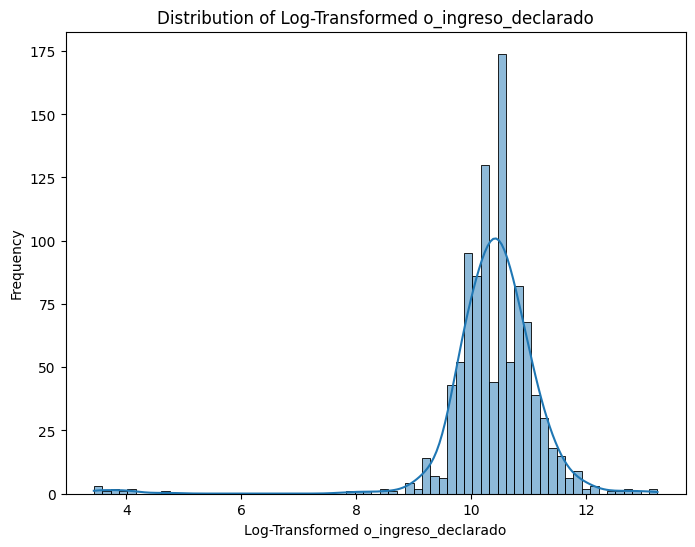

In [823]:
# prompt: Realizar en base a la distribución de la variable 'o_ingreso_declarado', una transformación adecuada aplicar en un modelo predictivo, el resultado debe ser numérico y debe sustituir la variable original.

# Apply a log transformation to 'o_ingreso_declarado' to handle its distribution
# Add a small constant (e.g., 1) before taking the log to handle zero values,
# although based on the describe() output, it seems all values are positive.
# Using np.log1p (log(1+x)) is a robust way to handle potential zeros gracefully.
df['o_ingreso_declarado_log'] = np.log1p(df['o_ingreso_declarado'])

# Replace the original column with the transformed column
df = df.drop('o_ingreso_declarado', axis=1)
df = df.rename(columns={'o_ingreso_declarado_log': 'o_ingreso_declarado'})

# Verify the transformation by checking the distribution and info
print("\nInfo after transformation:")
df.info()

print("\nDescription after transformation:")
display(df['o_ingreso_declarado'].describe())

# Optional: Plot the distribution of the transformed variable to visually inspect
plt.figure(figsize=(8, 6))
sns.histplot(df['o_ingreso_declarado'], kde=True)
plt.title('Distribution of Log-Transformed o_ingreso_declarado')
plt.xlabel('Log-Transformed o_ingreso_declarado')
plt.ylabel('Frequency')
plt.show()


In [824]:

# Análisis de la variable o_ingreso_declarado

# Distribución de o_ingreso_declarado

# Segmentación por cuantiles


# Crear bins basados en los cuantiles

# Transformación sugerida: Logaritmo
# Dada la posible asimetría (sesgo positivo) que se observa en la distribución (histograma),
# una transformación logarítmica (np.log1p para manejar valores cero si los hubiera) podría ayudar
# a hacer la distribución más simétrica, lo que a menudo mejora el rendimiento de modelos lineales
# y modelos basados en distancias.

# Verificar si hay valores no positivos antes de aplicar log

# Visualizar la distribución después de la transformación logarítmica

# La elección entre segmentación por cuantiles y transformación logarítmica (u otra como raíz cuadrada, Box-Cox si es apropiado)
# dependerá del modelo predictivo específico que se vaya a utilizar y de cómo maneja cada transformación.
# - La segmentación por cuantiles crea una variable categórica ordenada. Es útil para modelos basados en árboles
#   o cuando se quiere capturar efectos no lineales de manera simple.
# - La transformación logarítmica hace que la variable sea más numérica y menos sesgada, lo que es beneficioso
#   para modelos lineales o modelos que asumen normalidad o simetría en las características.

# Sugerencia adicional: Root transformation (sqrt) o Box-Cox/Yeo-Johnson
# Si la transformación logarítmica aún deja algo de sesgo o si hay valores <= 0, otras opciones son:
# - Raíz cuadrada: `df['o_ingreso_declarado_sqrt'] = np.sqrt(df['o_ingreso_declarado'])` (si no hay negativos)
# - Box-Cox o Yeo-Johnson: Estas son transformaciones más flexibles que pueden determinar la mejor
#   transformación a partir de los datos. Requieren scikit-learn: `from sklearn.preprocessing import PowerTransformer`
#   `pt = PowerTransformer(method='box-cox')` (solo para positivos) o `pt = PowerTransformer(method='yeo-johnson')` (para cualquier valor).
#   `df['o_ingreso_declarado_transformed'] = pt.fit_transform(df[['o_ingreso_declarado']])`

# Para modelos predictivos, se podría probar tanto la variable segmentada ('o_ingreso_declarado_quantile')
# como la variable transformada numéricamente (e.g., 'o_ingreso_declarado_log') por separado o incluso
# en conjunto para ver cuál mejora el rendimiento.


In [825]:
df_numeric.columns

Index(['o_Zero', 'o_nivel_antiguedad_laboral', 'o_ingreso_declarado', 'o_edad',
       'o_clr_score', 'm_Entidades', 'm_Exposición', 'm_Deuda',
       'm_Rel_DeudaPrincipal', 'hora_sin', 'hora_cos', 'EduLabel', 'CleLabel'],
      dtype='object')

In [826]:
df.value_counts('o_ingreso_declarado')

,count
o_ingreso_declarado,
10.31,79
10.60,67
10.82,58
10.46,57
10.13,55
...,...
12.68,1
12.79,1
12.90,1


In [827]:
# prompt: Preparar las variables numéricas, en función de la distribucíon de cada una, para aplicarlas en en modelo de aprendizaje automático, de manera que maximice el resultado

# Seleccionar las columnas numéricas para el escalado
numeric_cols_to_scale = ['o_nivel_antiguedad_laboral', 'o_ingreso_declarado', 'o_edad',
       'o_clr_score', 'm_Entidades', 'm_Exposición', 'm_Deuda',
       'm_Rel_DeudaPrincipal', 'hora_sin', 'hora_cos', 'EduLabel', 'CleLabel']

# Filter the list to include only columns present in the DataFrame
existing_numeric_cols_to_scale = [col for col in numeric_cols_to_scale if col in df.columns]

# Aplicar MinMaxScaler a las columnas numéricas
scaler = MinMaxScaler()
# Apply scaling only to the existing numeric columns
df[existing_numeric_cols_to_scale] = scaler.fit_transform(df[existing_numeric_cols_to_scale])

# Mostrar la información y las primeras filas del DataFrame con las variables numéricas escaladas
print("DataFrame después de escalar las variables numéricas:")
df_numeric_scaled = df.select_dtypes(include=np.number)
df_numeric_scaled.info()
display(df_numeric_scaled.head())


DataFrame después de escalar las variables numéricas:
<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   o_Zero                      1004 non-null   int64  
 1   o_nivel_antiguedad_laboral  1004 non-null   float64
 2   o_edad                      1004 non-null   float64
 3   o_clr_score                 1004 non-null   float64
 4   m_Entidades                 1004 non-null   float64
 5   m_Exposición                1004 non-null   float64
 6   m_Deuda                     1004 non-null   float64
 7   m_Rel_DeudaPrincipal        1004 non-null   float64
 8   hora_sin                    1004 non-null   float64
 9   hora_cos                    1004 non-null   float64
 10  EduLabel                    1004 non-null   float64
 11  CleLabel                    1004 non-null   float64
 12  o_ingreso_declarado         10

,o_Zero,o_nivel_antiguedad_laboral,o_edad,o_clr_score,m_Entidades,m_Exposición,m_Deuda,m_Rel_DeudaPrincipal,hora_sin,hora_cos,EduLabel,CleLabel,o_ingreso_declarado
m_Documento,,,,,,,,,,,,,
38753940,0,1.00,0.43,0.44,0.25,0.01,0.01,0.44,0.37,0.02,0.25,1.00,0.58
34006632,0,0.00,0.41,0.59,0.25,0.03,0.03,0.43,0.07,0.75,0.25,0.29,0.69
37438759,0,0.00,0.72,0.50,0.58,0.09,0.08,0.33,0.37,0.98,0.50,0.14,0.73
36127012,0,0.00,0.54,0.69,0.08,0.07,0.06,0.74,0.25,0.93,0.25,1.00,0.68
13295068,0,0.00,0.85,0.63,0.00,0.02,0.01,0.25,0.93,0.25,0.75,1.00,0.71


In [828]:
df_numeric_scaled.describe()

,o_Zero,o_nivel_antiguedad_laboral,o_edad,o_clr_score,m_Entidades,m_Exposición,m_Deuda,m_Rel_DeudaPrincipal,hora_sin,hora_cos,EduLabel,CleLabel,o_ingreso_declarado
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,0.24,0.29,0.40,0.65,0.19,0.06,0.06,0.59,0.36,0.37,0.58,0.54,0.71
std,0.42,0.36,0.24,0.19,0.17,0.09,0.09,0.25,0.31,0.35,0.25,0.33,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.20,0.52,0.08,0.01,0.01,0.41,0.07,0.07,0.50,0.29,0.68
50%,0.00,0.00,0.39,0.66,0.17,0.03,0.03,0.57,0.25,0.25,0.50,0.57,0.72
75%,0.00,0.67,0.57,0.79,0.25,0.08,0.07,0.79,0.63,0.63,0.75,0.86,0.75
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [829]:
df_numeric.columns

Index(['o_Zero', 'o_nivel_antiguedad_laboral', 'o_ingreso_declarado', 'o_edad',
       'o_clr_score', 'm_Entidades', 'm_Exposición', 'm_Deuda',
       'm_Rel_DeudaPrincipal', 'hora_sin', 'hora_cos', 'EduLabel', 'CleLabel'],
      dtype='object')

In [830]:
# Seleccionar las variables numéricas que se discretizarán por cuantiles
vars_to_discretize_quantiles = ['o_ingreso_declarado', 'm_Entidades',
                                 'm_Exposición', 'm_Deuda']

# Discretizar cada variable seleccionada por cuantiles
for col in vars_to_discretize_quantiles:
  if col in df.columns:
    # Crear 4 bins (quintiles) basados en los cuantiles
    df[col + '_quantile_bin'] = pd.qcut(df[col], q=5, labels=False, duplicates='drop')
    # Convertir la nueva columna discretizada a tipo 'category'
    df[col + '_quantile_bin'] = df[col + '_quantile_bin'].astype('category')
  else:
    print(f"Warning: Column '{col}' not found in DataFrame for quantile discretization.")


original_cols_to_drop = vars_to_discretize_quantiles
df = df.drop(original_cols_to_drop, axis=1)

# Mostrar las primeras filas del DataFrame con las nuevas variables discretizadas
print("\nDataFrame después de discretizar por cuantiles:")
display(df.head())

# Mostrar la información del DataFrame para ver los tipos de datos de las
# nuevas columnas
df.info()


DataFrame después de discretizar por cuantiles:


,o_Zero,o_nivel_antiguedad_laboral,o_edad,o_clr_score,m_Rel_DeudaPrincipal,m_Var_dueda_3M,m_Sin_Ficha,m_Malos,m_Q_irregular_12m,m_Mejora,...,m_Grupo_i_A,m_Grupo_i_B1,m_Grupo_i_C,m_Grupo_i_C1,EduLabel,CleLabel,o_ingreso_declarado_quantile_bin,m_Entidades_quantile_bin,m_Exposición_quantile_bin,m_Deuda_quantile_bin
m_Documento,,,,,,,,,,,,,,,,,,,,,
38753940,0,1.00,0.43,0.44,0.44,0,0,0,0,0,...,False,False,True,False,0.25,1.00,0,2,1,1
34006632,0,0.00,0.41,0.59,0.43,0,0,0,0,0,...,False,False,True,False,0.25,0.29,1,2,2,2
37438759,0,0.00,0.72,0.50,0.33,0,0,0,0,0,...,False,False,True,False,0.50,0.14,3,3,3,3
36127012,0,0.00,0.54,0.69,0.74,0,0,0,0,0,...,False,True,False,False,0.25,1.00,1,0,3,3
13295068,0,0.00,0.85,0.63,0.25,0,0,0,1,0,...,False,True,False,False,0.75,1.00,2,0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 75 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   o_Zero                                       1004 non-null   int64   
 1   o_nivel_antiguedad_laboral                   1004 non-null   float64 
 2   o_edad                                       1004 non-null   float64 
 3   o_clr_score                                  1004 non-null   float64 
 4   m_Rel_DeudaPrincipal                         1004 non-null   float64 
 5   m_Var_dueda_3M                               1004 non-null   category
 6   m_Sin_Ficha                                  1004 non-null   category
 7   m_Malos                                      1004 non-null   category
 8   m_Q_irregular_12m                            1004 non-null   category
 9   m_Mejora                                     1004 non-nul

In [831]:
df.describe()

,o_Zero,o_nivel_antiguedad_laboral,o_edad,o_clr_score,m_Rel_DeudaPrincipal,hora_sin,hora_cos,EduLabel,CleLabel
count,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00,1004.00
mean,0.24,0.29,0.40,0.65,0.59,0.36,0.37,0.58,0.54
std,0.42,0.36,0.24,0.19,0.25,0.31,0.35,0.25,0.33
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.20,0.52,0.41,0.07,0.07,0.50,0.29
50%,0.00,0.00,0.39,0.66,0.57,0.25,0.25,0.50,0.57
75%,0.00,0.67,0.57,0.79,0.79,0.63,0.63,0.75,0.86
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [832]:
df.info(['o_Zero'])

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 38753940 to 42719687
Data columns (total 75 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   o_Zero                                       1004 non-null   int64   
 1   o_nivel_antiguedad_laboral                   1004 non-null   float64 
 2   o_edad                                       1004 non-null   float64 
 3   o_clr_score                                  1004 non-null   float64 
 4   m_Rel_DeudaPrincipal                         1004 non-null   float64 
 5   m_Var_dueda_3M                               1004 non-null   category
 6   m_Sin_Ficha                                  1004 non-null   category
 7   m_Malos                                      1004 non-null   category
 8   m_Q_irregular_12m                            1004 non-null   category
 9   m_Mejora                                     1004 non-nul

In [833]:
# Define 'Zero' como la variable objetivo
y = df['o_Zero']

# Divide los datos en conjuntos de entrenamiento y prueba
X_df = df.drop('o_Zero', axis=1)

num_data_points = len(X_df)
cut = int(.7 * num_data_points)

X_train = X_df[:cut]
y_train = y[:cut] # Usa la variable objetivo correcta 'y'
X_test = X_df[cut:]
y_test = y[cut:]
print(X_train.shape, X_test.shape)

(702, 74) (302, 74)


In [834]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression(max_iter=1000, solver='liblinear')
logistic.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [835]:
print('Logistic Regression mean accuracy: %f' % logistic.score(X_test, y_test))

Logistic Regression mean accuracy: 0.874172


              precision    recall  f1-score   support

           0       0.90      0.96      0.93       253
           1       0.68      0.43      0.53        49

    accuracy                           0.87       302
   macro avg       0.79      0.69      0.73       302
weighted avg       0.86      0.87      0.86       302

Confusion Matrix:
[[243  10]
 [ 28  21]]


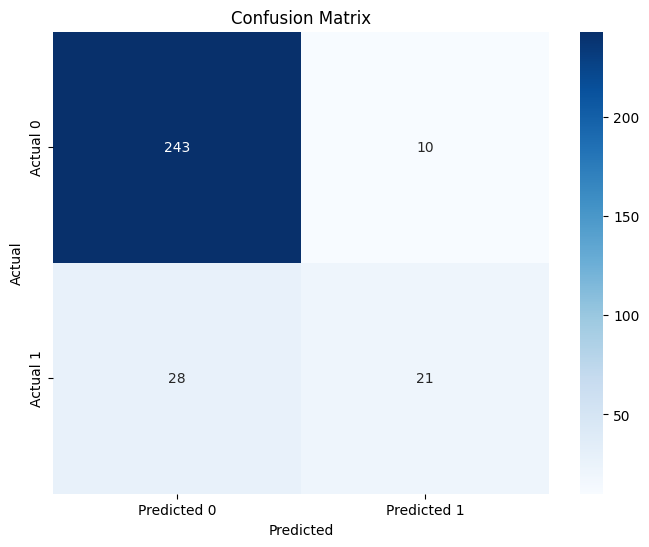

In [836]:
#Evalúo el resultado del modelo LogisticRegression.


# Predict on the test set
y_pred = logistic.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

                                        Feature  Importance
62                                  m_Grupo_b_R        2.23
33              o_status_voucher_decommissioned        1.03
8                                      m_Mejora        0.87
26  o_status_usuario_user_unvalidated_birthdate        0.69
45                o_navegador_familia_Instagram        0.64
4                                m_Var_dueda_3M        0.60
69                                     CleLabel        0.50
63                                 m_Grupo_b_RR        0.49
5                                   m_Sin_Ficha        0.46
41           o_relacion_laboral_indep_sin_local        0.45


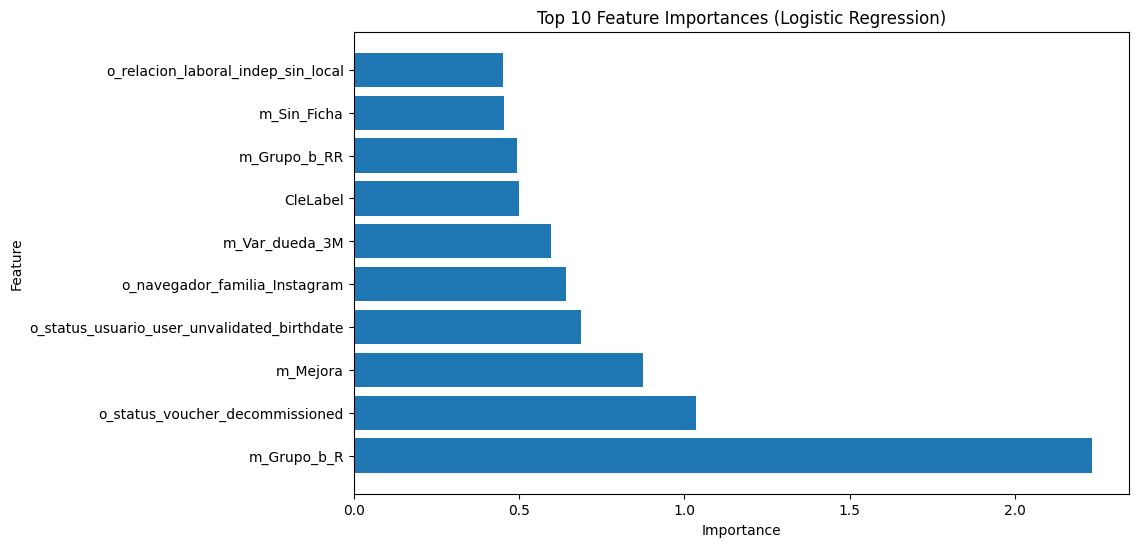

In [837]:

feature_importances = logistic.coef_[0]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N features (e.g., top 10)
print(feature_importance_df.head(10))


# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.show()